In [26]:
import os
from os import walk

import pandas as pd
import numpy as np
import sys
import re

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.pyplot import *

import json
import numpy as np
import seaborn as sns

from collections import Counter

%matplotlib inline

pd.set_option('display.max_rows', 9000)
pd.set_option('display.max_columns', 1500)
pd.set_option('max_colwidth', 400)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

palette_list = list(sns.color_palette("colorblind"))

In [27]:
results_data_path = 'results_data/'

In [28]:
resolution_list = ["one_field", "two_field", "p_group", "e_group"]

coverage_list = [100, 75, 50, 20, 10, 5, 2, 1]

In [29]:
ds_dict = dict()

for coverage in coverage_list:
    with open(f'result_data/results_{str(coverage)}.json', 'r') as infile:
        coverage_dict = json.load(infile)

    #Reformat dict:
    ds_dict[coverage] = coverage_dict

    # for resolution, tool_dict in coverage_dict.items():
    #     ds_dict[f'{coverage}X'][resolution] = dict()

    #     for tool, locus_dict in tool_dict.items():
    #         ds_dict[f'{coverage}X'][resolution][tool] = locus_dict

with open("result_data/full_downsample_results.json", "w") as outfile:
    json.dump(ds_dict, outfile)

In [30]:
resolution = '2-field'
allele = 'HLA-I'



accuracy_dict = dict()
for cov, resolutions_dict in ds_dict.items():
    for tool, locus_dict in resolutions_dict[resolution].items():
        if tool not in accuracy_dict:
            accuracy_dict[tool] = dict()
        accuracy_dict[tool][cov] = locus_dict[allele]['typing_accuracy']

df = pd.DataFrame(accuracy_dict)

# Plot results

In [31]:
tool_rename = {
    'Kourami' : 'Kourami',
    'HLA-LA'  : 'HLA*LA', 
    'Optitype' : 'Optitype',
    'Hisatgenotype'	: 'HISAT-genotype',
    'STC-seq' : 'STC-Seq',
}


idx = pd.IndexSlice

def performance_coverage_plot(resolution = '2-field'):
    """
    resolution:    One of four options: ['2-field', '1-field', 'P group', 'pseudosequence']
    allele index:  Either specific gene ['A', 'B', 'C', 'DRB1', 'DQB1'] or a group ['HLA-I', 'HLA-II', 'Evaxion', 'Total']
    
    """
    fig, axs = plt.subplot_mosaic([['(A)', '(B)']], constrained_layout=True, figsize=(20,8))
    figpanels = ['(A)', '(B)']

    for label, ax in axs.items():

        if label == '(A)':
            locus = 'HLA-I'
            title = 'HLA-A, -B and -C'
        else:
            locus = 'HLA-II'
            title = 'HLA-DRB1 and -DQB1'

        accuracy_dict = dict()
        for cov, resolutions_dict in ds_dict.items():
            for tool, locus_dict in resolutions_dict[resolution].items():
                tool_name = tool_rename[tool]
                if tool_name not in accuracy_dict:
                    accuracy_dict[tool_name] = dict()
                accuracy_dict[tool_name][cov] = locus_dict[locus]['typing_accuracy']

        accuracy_df = pd.DataFrame(accuracy_dict)
        accuracy_df = accuracy_df[['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']]

        if locus in ('HLA-II', 'DRB1', 'DQB1'):
            accuracy_df = accuracy_df.drop('Optitype', axis=1)

        accuracy_df.rename_axis('labels', axis=1)

        accuracy_df.plot(marker='o', color = palette_list, ax=ax, linewidth=3, sharey=True)
        
        ax.set_xlabel("Depth of coverage", size=18)
        ax.set_ylabel("Accuracy (%)", size=18)
        
        ax.set_xticks(coverage_list, size=18)
        ax.set_xticklabels(coverage_list[:-2] + [''] + [1])
        ax.set_yticks(list(range(0,101,10)))
        ax.set_ylim(0,101)
        
        ax.yaxis.grid()
        
        plt.rcParams.update({'font.size': 18})
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        
        ax.set_title(f"Typing accuracy for {title} in 2-field resolution", fontsize=20)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.02, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif')
        
        legend = ax.legend()
        legend.texts[0].set_text("Kourami")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    fig.tight_layout()


    
    return plt, axs, accuracy_df
    

/tmp/ipykernel_1879726/156679971.py:74: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


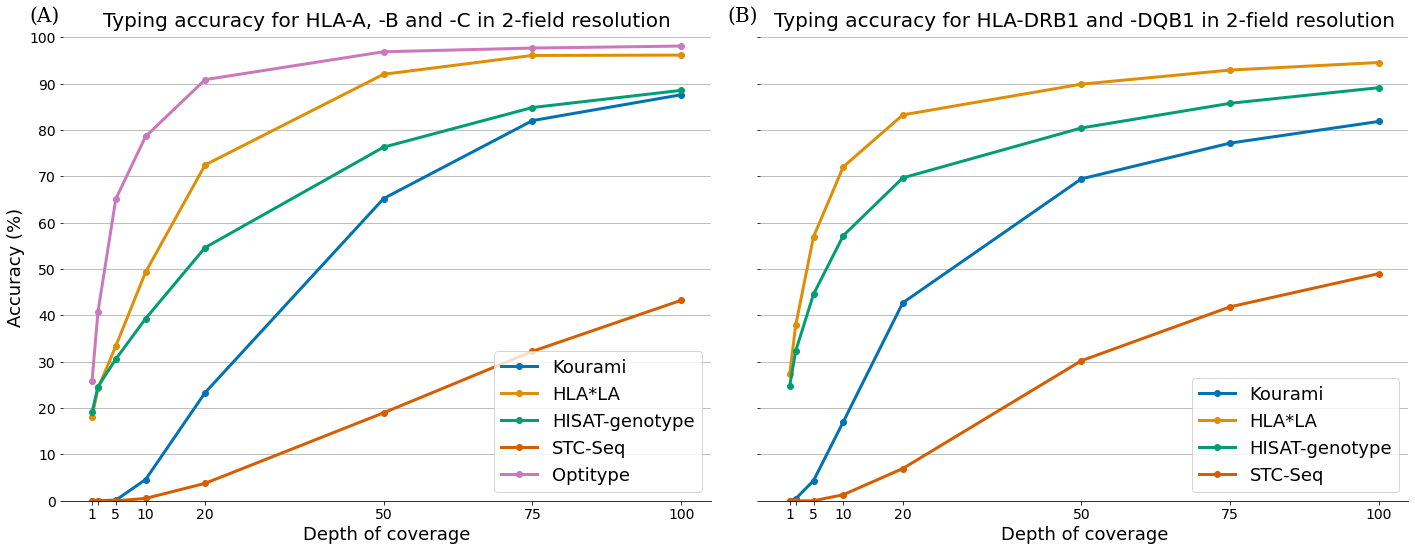

In [32]:
resolution = '2-field'

fig, axs, accuracy_df = performance_coverage_plot(resolution = resolution)
fig.savefig(f'plots/downsample_classes_{resolution}.eps')

# Individual class I 

In [33]:
idx = pd.IndexSlice

def performance_coverage_plot(resolution = '2-field'):

    fig, axs = plt.subplot_mosaic([['(C)', '(D)', '(E)']], constrained_layout=True, figsize=(25,8))
    figpanels = ['(C)', '(D)', '(E)']

    for label, ax in axs.items():

        if label == '(C)':
            locus = 'A'
        elif label == '(D)':
            locus = 'B'
        else:
            locus = 'C'
    
        accuracy_dict = dict()
        for cov, resolutions_dict in ds_dict.items():
            for tool, locus_dict in resolutions_dict[resolution].items():
                tool_name = tool_rename[tool]
                if tool_name not in accuracy_dict:
                    accuracy_dict[tool_name] = dict()
                accuracy_dict[tool_name][cov] = locus_dict[locus]['typing_accuracy']

        accuracy_df = pd.DataFrame(accuracy_dict)

        if locus in ('HLA-II', 'DRB1', 'DQB1'):
            accuracy_df = accuracy_df.drop('Optitype', axis=1)

        accuracy_df.rename_axis('labels', axis=1)
        accuracy_df = accuracy_df[['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']]


        accuracy_df.plot(marker='o', color = palette_list, ax=ax, linewidth=3, sharey=True)
        
        ax.set_xlabel("Depth of coverage", size=16)
        ax.set_ylabel("Accuracy (%)", size=16)
        
        ax.set_xticks(coverage_list, size=16)
        ax.set_xticklabels(coverage_list[:-2] + [''] + [1])
        ax.set_yticks(list(range(0,101,10)))
        ax.set_ylim(0,101)
        
        ax.yaxis.grid()
        
        plt.rcParams.update({'font.size': 16})
        plt.rc('xtick', labelsize=16)
        plt.rc('ytick', labelsize=16)
        
        ax.set_title(f"Typing accuracy for HLA-{locus} in 2-field resolution", fontsize=20)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.02, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif')
        
        legend = ax.legend()
        legend.texts[0].set_text("Kourami")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        #plt.axhline(y=97.83)

    fig.tight_layout()


    
    return plt, axs, accuracy_df
    

/tmp/ipykernel_1879726/4222299344.py:63: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


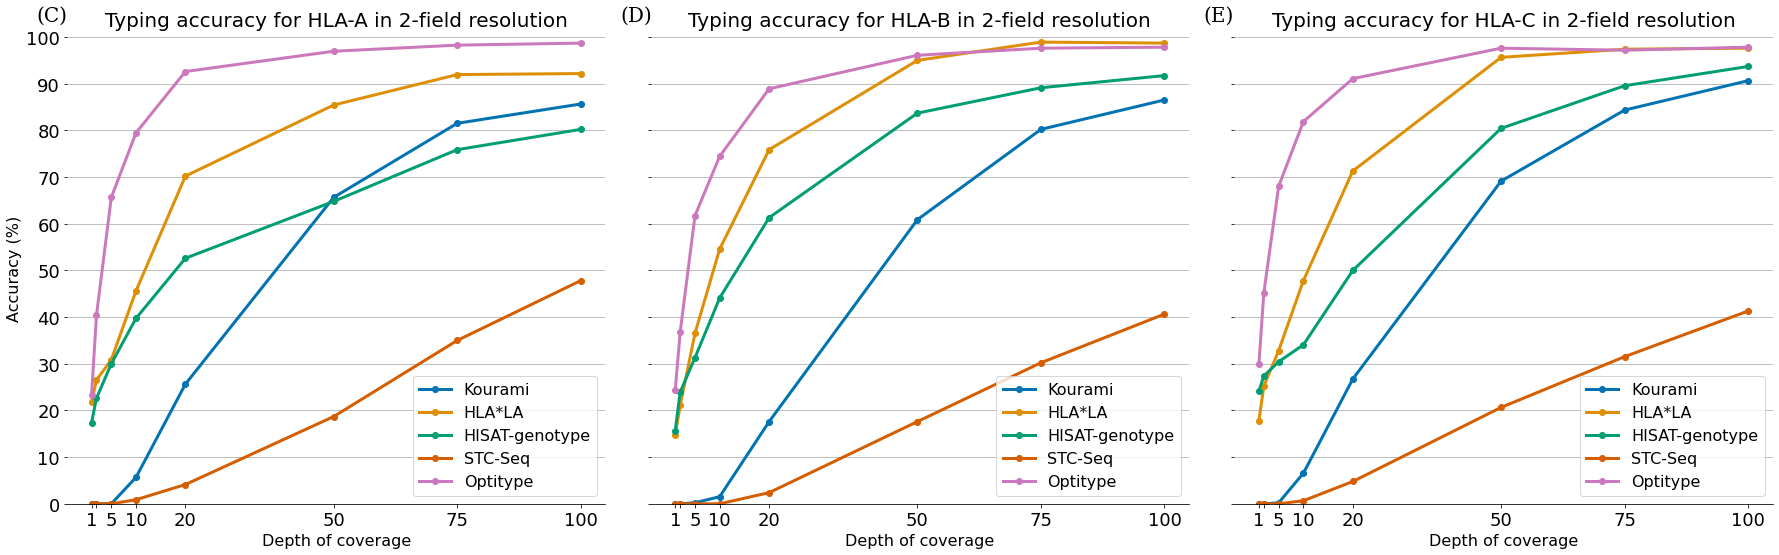

In [35]:
fig, axs, accuracy_df = performance_coverage_plot(resolution = '2-field')
fig.savefig('plots/downsampleIandABC.eps')

# Individual Class II 

In [36]:
idx = pd.IndexSlice

def performance_coverage_plot(resolution = '2-field'):

    fig, axs = plt.subplot_mosaic([['(F)', '(G)']], constrained_layout=True, figsize=(20,8))
    figpanels = ['(F)', '(G)']

    for label, ax in axs.items():

        if label == '(F)':
            locus = 'DRB1'
            title = 'HLA Class I alleles (HLA-A, -B and -C)'
        else:
            locus = 'DQB1'
            title = 'HLA Class II alleles (HLA-DRB1 and -DQB1)'

        accuracy_dict = dict()
        for cov, resolutions_dict in ds_dict.items():
            for tool, locus_dict in resolutions_dict[resolution].items():
                tool_name = tool_rename[tool]
                if tool_name not in accuracy_dict:
                    accuracy_dict[tool_name] = dict()
                accuracy_dict[tool_name][cov] = locus_dict[locus]['typing_accuracy']

        accuracy_df = pd.DataFrame(accuracy_dict)
        accuracy_df = accuracy_df[['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']]

        if locus in ('HLA-II', 'DRB1', 'DQB1'):
            accuracy_df = accuracy_df.drop('Optitype', axis=1)

        accuracy_df.rename_axis('labels', axis=1)
        accuracy_df.plot(marker='o', color = palette_list, ax=ax, linewidth=3, sharey=True)

        
        ax.set_xlabel("Depth of coverage", size=16)
        ax.set_ylabel("Accuracy (%)", size=16)
        
        ax.set_xticks(coverage_list, size=16)
        ax.set_xticklabels(coverage_list[:-2] + [''] + [1])
        ax.set_yticks(list(range(0,101,10)))
        ax.set_ylim(0,101)
        
        ax.yaxis.grid()
        
        plt.rcParams.update({'font.size': 16})
        plt.rc('xtick', labelsize=16)
        plt.rc('ytick', labelsize=16)
        
        ax.set_title(f"Typing accuracy for HLA-{locus} in 2-field resolution", fontsize=20)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.02, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif')
        
        legend = ax.legend()
        legend.texts[0].set_text("Kourami")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    fig.tight_layout()


    
    return plt, axs, accuracy_df
    

/tmp/ipykernel_1879726/1312385257.py:61: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


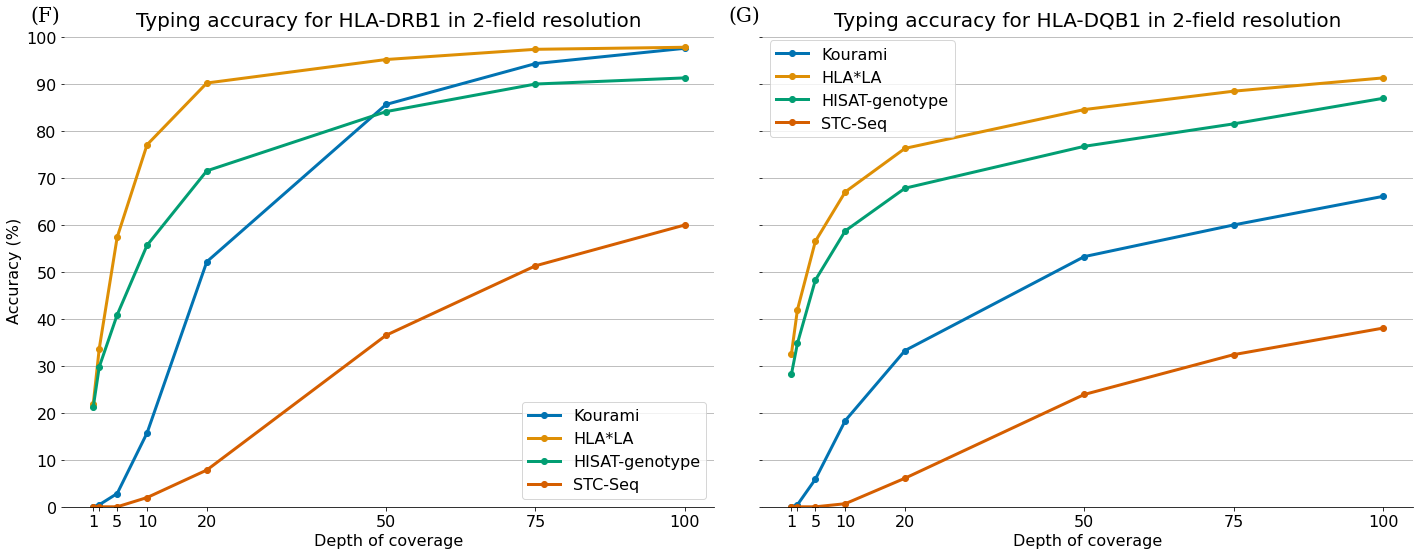

In [37]:
fig, axs, accuracy_df = performance_coverage_plot(resolution = '2-field')
fig.savefig('plots/downsampleIandDRB1DQB1.eps')

# All in one

In [38]:
idx = pd.IndexSlice

def performance_coverage_plot(ax, resolution = 'P group', locus = 'HLA-I', label='A', legend=False, title=''):

    accuracy_dict = dict()
    for cov, resolutions_dict in ds_dict.items():
        for tool, locus_dict in resolutions_dict[resolution].items():
            tool_name = tool_rename[tool]
            if tool_name not in accuracy_dict:
                accuracy_dict[tool_name] = dict()
            accuracy_dict[tool_name][cov] = locus_dict[locus]['typing_accuracy']

    accuracy_df = pd.DataFrame(accuracy_dict)
    accuracy_df = accuracy_df[['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']]
    
    if locus in ('HLA-II', 'DRB1', 'DQB1'):
        accuracy_df = accuracy_df.drop('Optitype', axis=1)

    accuracy_df.rename_axis('labels', axis=1)

    accuracy_df.plot(marker='o', color = palette_list, ax=ax, linewidth=3, sharey=True)

    ax.set_xlabel("Depth of coverage", size=18)
    ax.set_ylabel("Typing accuracy (%)", size=18)
    
    ax.set_xticks(coverage_list, size=18)
    ax.set_xticklabels(coverage_list[:-2] + [''] + [1])
    ax.set_yticks(list(range(0,101,10)))
    ax.set_ylim(0,101)
    
    ax.yaxis.grid()
    
    plt.rcParams.update({'font.size': 18})
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    
    ax.set_title(f"{title}", fontsize=20)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.05, 1.0, label, transform=ax.transAxes + trans,
            fontsize=20, va='bottom', fontfamily='serif', weight='bold')
    
    if legend == False:
        ax.get_legend().remove()
    else:
        legend = ax.legend()

    #legend.texts[0].set_text("Kourami")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return ax

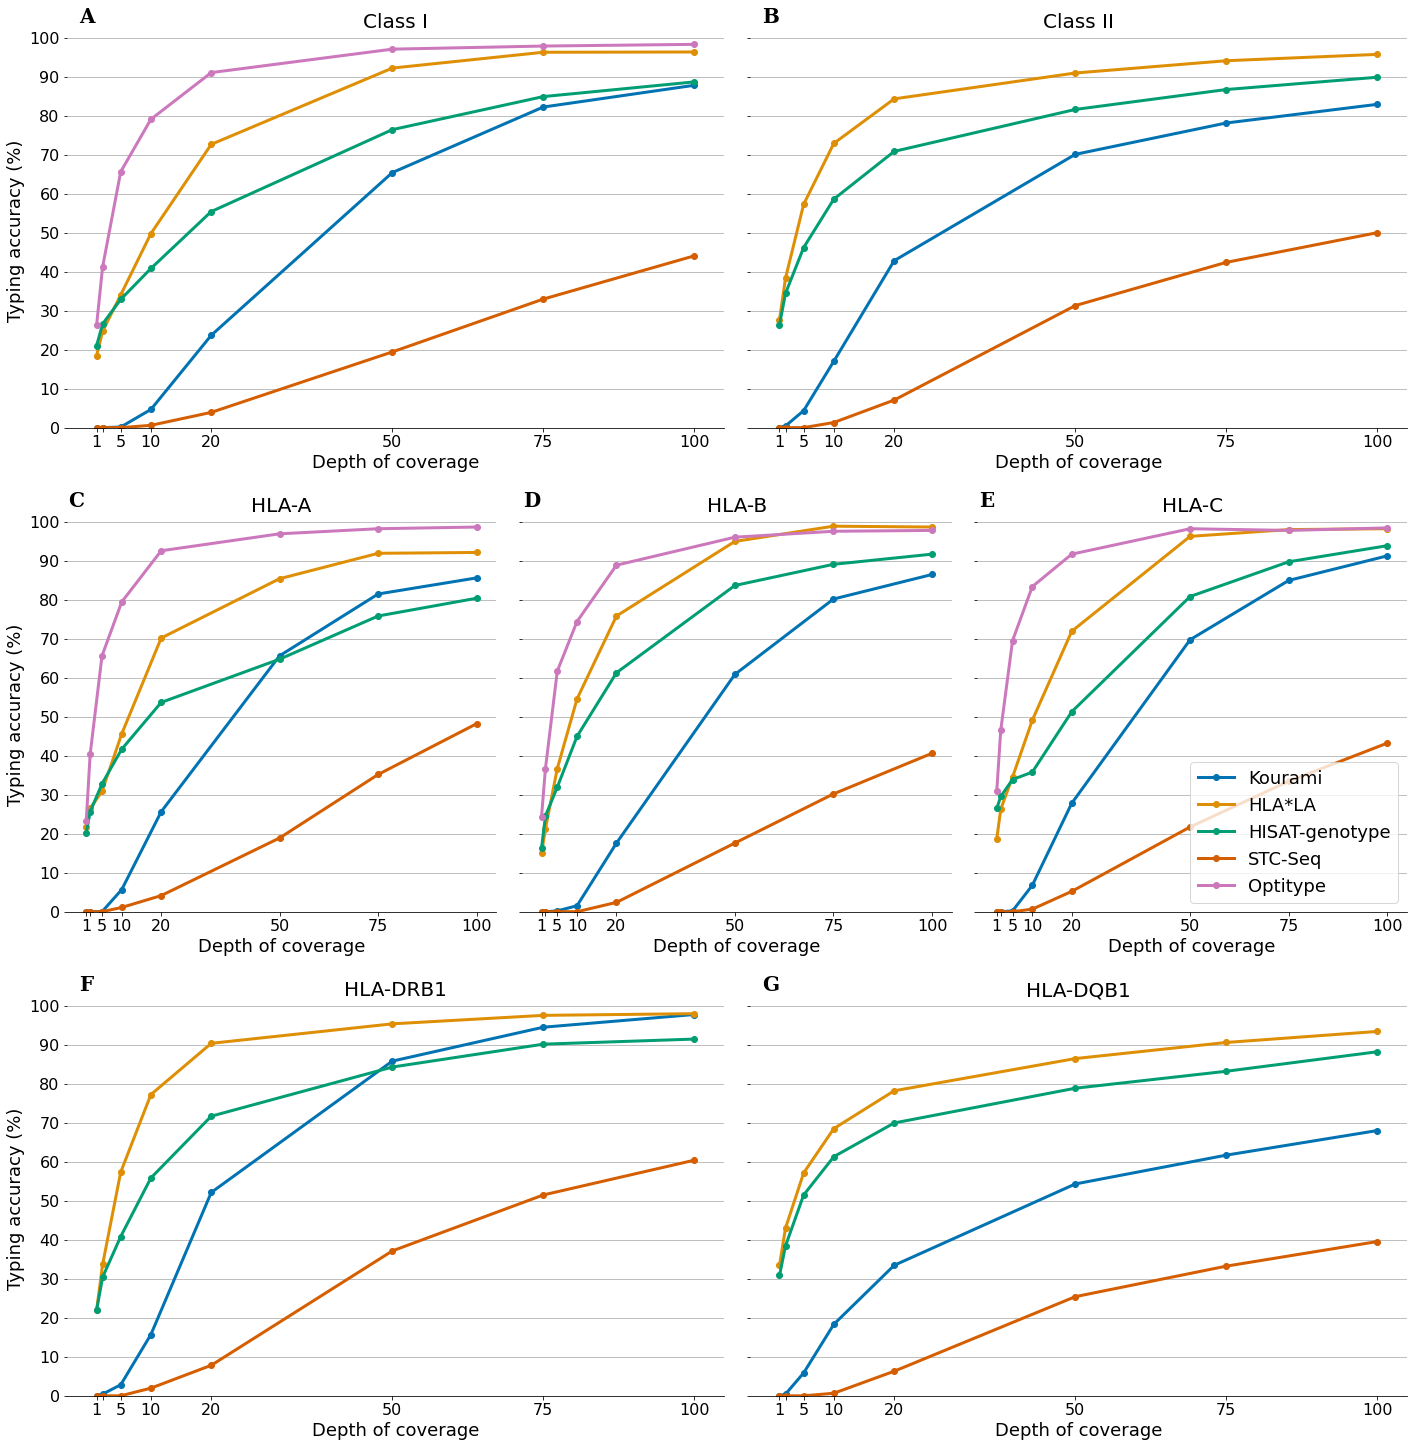

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [39]:
fig = plt.figure(figsize=(20, 40))

ax1 = plt.subplot2grid((6, 6), (0, 0), colspan=3)
ax2 = plt.subplot2grid((6, 6), (0, 3), colspan=3)
ax3 = plt.subplot2grid((6, 6), (1, 0), colspan=2)
ax4 = plt.subplot2grid((6, 6), (1, 2), colspan=2)
ax5 = plt.subplot2grid((6, 6), (1, 4), colspan=2)
ax6 = plt.subplot2grid((6, 6), (2, 0), colspan=3)
ax7 = plt.subplot2grid((6, 6), (2, 3), colspan=3)


plt.subplots_adjust(wspace = 1, hspace = 1) #make the figure look better

performance_coverage_plot(ax=ax1, locus = 'HLA-I', label='A', title='Class I')
performance_coverage_plot(ax=ax2, locus = 'HLA-II', label='B', title='Class II')
performance_coverage_plot(ax=ax3, locus = 'A', label='C', title='HLA-A')
performance_coverage_plot(ax=ax4, locus = 'B', label='D', title='HLA-B')
performance_coverage_plot(ax=ax5, locus = 'C', label='E', title='HLA-C', legend=True)
performance_coverage_plot(ax=ax6, locus = 'DRB1', label='F', title='HLA-DRB1')
performance_coverage_plot(ax=ax7, locus = 'DQB1', label='G', title='HLA-DQB1')

plt.tight_layout()
plt.show()
fig.savefig('plots/downsampling_full.eps', bbox_inches='tight')


# Time and memory use

In [17]:
#Load mean time and memory use for each tool for each coverage

#Load performance files:
memory_use_gb_dict = dict()
cpu_time_min_dict = dict()
wall_time_min_dict = dict()


for cov in coverage_list:
    
    memory_use_gb_dict[cov] = dict()
    cpu_time_min_dict[cov] = dict()
    wall_time_min_dict[cov] = dict()

    for tool in ['kourami', 'hla-la', 'optitype', 'hisatgenotype', 'stc-seq']:
        full_filepath =  f"../downsampling_results/output_{cov}X/1000_genomes_results/{tool}"

        #Make list of results for each tool:
        memory_use_list = list()
        cpu_time_list = list()
        wall_time_list = list()

        #Reset list of filenames for each tool
        tool_files = list()

        for (dirpath, dirnames, filenames) in walk(full_filepath):
            tool_files.extend(filenames)

        for file in tool_files:
            #Only include logfiles
            if file.endswith('.log'):
                with open(full_filepath + '/' + file, 'r') as infile:
                    for line in infile:
                        #Grab memory use
                        if line.startswith('    resources_used.mem'):
                            line_extract = line.split()[-1][:-2]

                            memory_gb = int(line_extract)/(10**6)

                            memory_use_list.append(memory_gb)

                        #Grab cputime 
                        if line.startswith('    resources_used.cput'):
                            line_extract = line.split()[-1]

                            time_min = (int(line_extract[-8:-6]) * 60) + int(line_extract[-5:-3]) + (int(line_extract[-2:]) / 60)

                            cpu_time_list.append(time_min)

                        #Grab walltime
                        if line.startswith('    resources_used.walltime'):
                            line_extract = line.split()[-1]

                            time_min = (int(line_extract[-8:-6]) * 60) + int(line_extract[-5:-3]) + (int(line_extract[-2:]) / 60)

                            wall_time_list.append(time_min)
                    
#        Add mean or median to each dict:

        memory_use_gb_dict[cov][tool] = np.median(memory_use_list)
        cpu_time_min_dict[cov][tool] = np.median(cpu_time_list)
        wall_time_min_dict[cov][tool] = np.median(wall_time_list)
        
#         memory_use_gb_dict[cov][tool] = np.mean(memory_use_list)
#         cpu_time_min_dict[cov][tool] = np.mean(cpu_time_list)
#         wall_time_min_dict[cov][tool] = np.mean(wall_time_list)


import pickle
with open('/work/nthu/publications/hlatyping/2022/data/memory_use_gb_dict_downsampling_plots.pkl', 'wb') as outfile:
    pickle.dump(memory_use_gb_dict, outfile)

with open('/work/nthu/publications/hlatyping/2022/data/cpu_time_min_dict_downsampling_plots.pkl', 'wb') as outfile:
    pickle.dump(cpu_time_min_dict, outfile)

with open('/work/nthu/publications/hlatyping/2022/data/cpu_time_min_dict_downsampling_plots.pkl', 'wb') as outfile:
    pickle.dump(wall_time_min_dict, outfile)

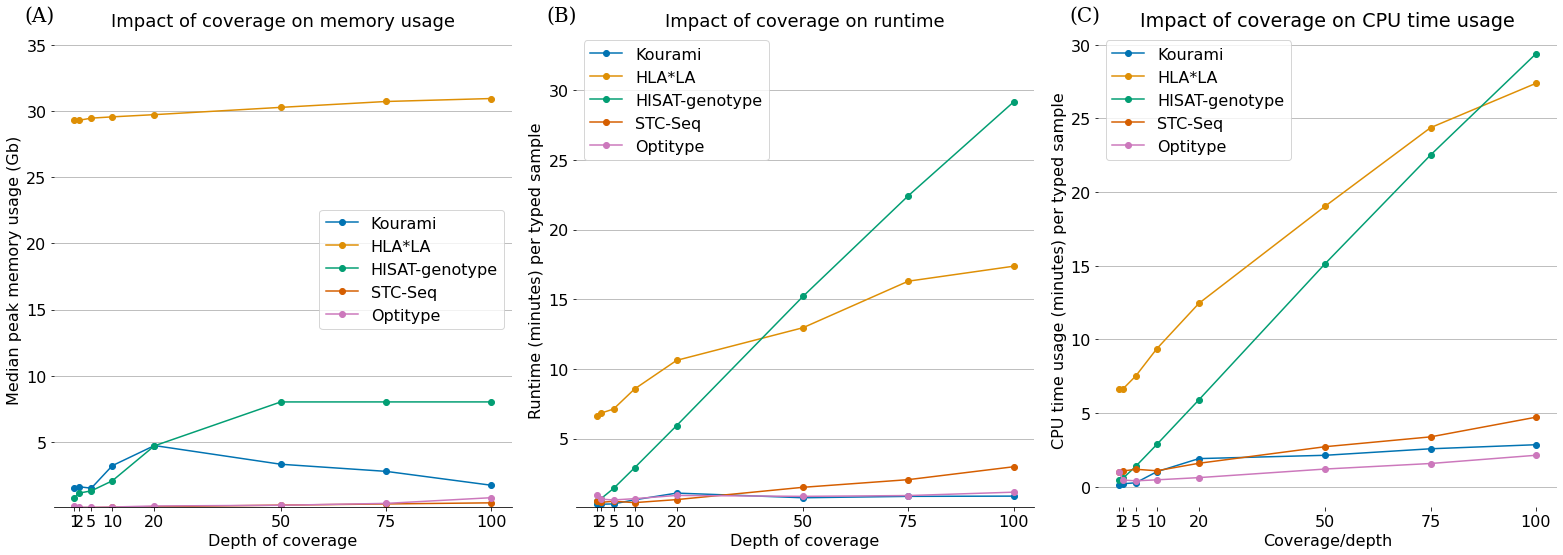

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [50]:
fig, axs = plt.subplot_mosaic([['(A)', '(B)', '(C)']], figsize=(22,8))
figpanels = ['(A)', '(B)']

for label, ax in axs.items():

    if label == '(A)':
        memory_df = pd.DataFrame(memory_use_gb_dict)

        memory_df = memory_df.T

        memory_df.rename(columns = {'kourami':'Kourami', 'hla-la':'HLA*LA', 'optitype':'Optitype', 'hisatgenotype':'HISAT-genotype', 'stc-seq': 'STC-Seq'}, inplace=True)
        memory_df = memory_df[['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']]


        memory_df.plot(marker='o', ax=ax, color=palette_list)

        ax.set_xlabel("Depth of coverage")
        ax.set_ylabel("Median peak memory usage (Gb)")

        ax.set_xticks(coverage_list)
        # ax.set_yticks(list(range(0,101,10)))

        ax.yaxis.grid()

        # plt.rcParams.update({'font.size': 14})
        # plt.rc('xtick', labelsize=14)
        # plt.rc('ytick', labelsize=14)

        #plt.title("The effect of coverage on memory use for HLA typing")
        
        ax.set_title("Impact of coverage on memory usage", size=18)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.02, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif')

        ax.set_ylim(0.1, max(memory_df['HLA*LA'])+5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)   

        

    if label == '(B)':
        wall_time_df = pd.DataFrame(wall_time_min_dict)

        wall_time_df = wall_time_df.T

        wall_time_df.rename(columns = {'kourami':'Kourami', 'hla-la':'HLA*LA', 'optitype':'Optitype', 'hisatgenotype':'HISAT-genotype', 'stc-seq': 'STC-Seq'}, inplace=True)
        wall_time_df = wall_time_df[['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']]


        wall_time_df.plot(marker='o', ax=ax, color=palette_list)

        ax.set_xlabel("Depth of coverage")
        ax.set_ylabel("Runtime (minutes) per typed sample")

        ax.set_xticks(coverage_list)
        
        ax.set_title("Impact of coverage on runtime", size=18)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.02, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif')

        ax.yaxis.grid()
        ax.set_ylim(0.1, max(wall_time_df['HISAT-genotype'])+5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)   

        plt.rcParams.update({'font.size': 16})
        plt.rc('xtick', labelsize=16)
        plt.rc('ytick', labelsize=16)


    if label == '(C)':
        cpu_time_df = pd.DataFrame(cpu_time_min_dict)

        cpu_time_df = cpu_time_df.T

        cpu_time_df.rename(columns = {'kourami':'Kourami', 'hla-la':'HLA*LA', 'optitype':'Optitype', 'hisatgenotype':'HISAT-genotype', 'stc-seq': 'STC-Seq'}, inplace=True)
        cpu_time_df = cpu_time_df[['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']]

        cpu_time_df.plot(marker='o', ax=ax, color=palette_list)

        ax.set_xlabel("Coverage/depth")
        ax.set_ylabel("")

        ax.set_xticks(coverage_list)
        # ax.set_yticks(list(range(0,101,10)))
        ax.set_title('Impact of coverage on CPU time usage')
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.02, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif')


        ax.yaxis.grid()
        ax.set_ylabel("CPU time usage (minutes) per typed sample")

        plt.rcParams.update({'font.size': 16})
        plt.rc('xtick', labelsize=16)
        plt.rc('ytick', labelsize=16)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)    


plt.tight_layout()
plt.show()

fig.savefig('plots/memory_time_usage_downsample.eps')